# Обучение нейронной сети для анализа тональности

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import re
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification
from torch.optim.lr_scheduler import ExponentialLR
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/tsa/sent_clean.csv', encoding='utf-8')
data = data[['issuerid', 'SentimentScore', 'MessageTextClean']]
data.head(2)

,issuerid,SentimentScore,MessageTextClean
0,153,2,⚠️🇷🇺#SELG #дивиденд сд Селигдар: дивиденды 202...
1,230,4,Ozon продолжает развивать специализированные ф...


In [ ]:
data.loc[data['SentimentScore']==0, 'SentimentScore'] = 1

In [ ]:
issuers = pd.read_excel('/content/drive/MyDrive/tsa/issuers.xlsx')
issuers.head(2)

,Unnamed: 0,issuerid,EMITENT_FULL_NAME,datetrackstart,datetrackend,BGTicker,OtherTicker
0,0,1,"""Акционерный коммерческий банк ""Держава"" публи...",2021-06-02 12:47:55.100,NaN,NaN,NaN
1,1,2,"""МОСКОВСКИЙ КРЕДИТНЫЙ БАНК"" (публичное акционе...",2021-06-02 12:47:55.100,NaN,CBOM RX,NaN


In [ ]:
data = data.merge(issuers[['issuerid', 'EMITENT_FULL_NAME']], on='issuerid', how='left')
data.head(2)

,issuerid,SentimentScore,MessageTextClean,EMITENT_FULL_NAME
0,153,2,⚠️🇷🇺#SELG #дивиденд сд Селигдар: дивиденды 202...,"Публичное акционерное общество ""Селигдар"""
1,230,4,Ozon продолжает развивать специализированные ф...,Озон Холдингс ПиЭлСи (эмитент депозитарных рас...


In [ ]:
names = pd.read_csv('/content/drive/MyDrive/tsa/company_names2.csv')
names.head(2)

,issuerid,l_syns
0,1,"['Держава', 'DERZP', 'DERZ', 'DERZHAVA', '""Акц..."
1,2,"['CBOM RX', '""МОСКОВСКИЙ КРЕДИТНЫЙ БАНК"" (публ..."


In [ ]:
df_names = pd.merge(data, names, on="issuerid", how="left")
df_names.head(2)

,issuerid,SentimentScore,MessageTextClean,EMITENT_FULL_NAME,l_syns
0,153,2,⚠️🇷🇺#SELG #дивиденд сд Селигдар: дивиденды 202...,"Публичное акционерное общество ""Селигдар""","['селигдар', 'SELG', 'Публичное акционерное об..."
1,230,4,Ozon продолжает развивать специализированные ф...,Озон Холдингс ПиЭлСи (эмитент депозитарных рас...,"['OZON RX', 'Озон Холдингс ПиЭлСи (эмитент деп..."


In [ ]:
df_names.isnull().sum()

issuerid             0
SentimentScore       0
MessageTextClean     1
EMITENT_FULL_NAME    3
l_syns               3
dtype: int64

In [ ]:
df_names.dropna(inplace=True)

In [ ]:
remove_question = lambda text: re.sub(r'\?{2,}', '', text)
df_names['MessageTextClean'] = df_names['MessageTextClean'].apply(remove_question)
remove_u200b = lambda text: re.sub(r'\u200b', '', text)
df_names['MessageTextClean'] = df_names['MessageTextClean'].apply(remove_u200b)
remove_backslash = lambda text: re.sub(r'\\[^ ]*', '', text)
df_names['MessageTextClean'] = df_names['MessageTextClean'].apply(remove_backslash)
remove_at = lambda text: re.sub(r'\@\S{2,}', '', text)
df_names['MessageTextClean'] = df_names['MessageTextClean'].apply(remove_at)
remove_site = lambda text: re.sub(r'http\S{2,}', '', text)
df_names['MessageTextClean'] = df_names['MessageTextClean'].apply(remove_site)
remove_space = lambda text: re.sub(r'\s{2,}', ' ', text)
df_names['MessageTextClean'] = df_names['MessageTextClean'].apply(remove_space)
remove_quotation = lambda text: re.sub(r'\"{2,}', '"', text)
df_names['MessageTextClean'] = df_names['MessageTextClean'].apply(remove_quotation)

In [ ]:
data = df_names.copy()

In [ ]:
data['SentimentScore'].value_counts()/data.shape[0]

SentimentScore
4    0.414755
3    0.378029
2    0.101669
5    0.081099
1    0.024448
Name: count, dtype: float64

In [ ]:
data['SentimentScore'].value_counts()

SentimentScore
4    3851
3    3510
2     944
5     753
1     227
Name: count, dtype: int64

<Axes: xlabel='SentimentScore', ylabel='Count'>

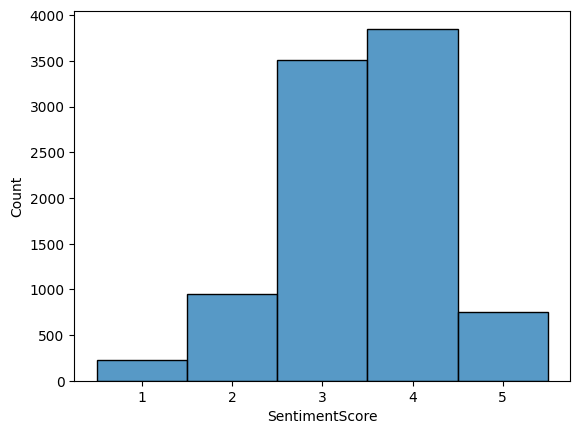

In [ ]:
sns.histplot(data, x='SentimentScore', discrete=True)

In [ ]:
train_data, val_data = train_test_split(data,
                                        stratify=data['SentimentScore'],
                                        random_state=77,
                                        test_size=0.3)
val_data, test_data = train_test_split(val_data,
                                        stratify=val_data['SentimentScore'],
                                        random_state=77,
                                        test_size=0.3)

In [ ]:
def make_prompt(text, name, tokenizer):
    prompt = ['[CLS]']
    prompt.extend(tokenizer.tokenize(name))
    prompt.append('[SEP]')
    prompt.extend(tokenizer.tokenize(text))
    return prompt

In [ ]:
class dataset(Dataset):
    def __init__(self, companies:list, texts: list, labels: list, tokenizer, max_len=512):
        self.len = len(texts)
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.texts = texts
        self.labels = labels
        self.companies = companies

    def __getitem__(self, idx):
        text = self.texts[idx].lower()
        company_name = self.companies[idx].lower()
        tokenized_prompt = make_prompt(text, company_name, self.tokenizer)
        label = self.labels[idx]

        maxlen = self.max_len
        if (len(tokenized_prompt) > maxlen):
          # truncate
          tokenized_prompt = tokenized_prompt[:maxlen]
        else:
          # pad
          tokenized_prompt = tokenized_prompt + ['[PAD]' for _ in range(maxlen - len(tokenized_prompt))]

        attn_mask = [1 if tok != '[PAD]' else 0 for tok in tokenized_prompt]

        ids = self.tokenizer.convert_tokens_to_ids(tokenized_prompt)

        return {
              'ids': torch.tensor(ids, dtype=torch.long),
              'mask': torch.tensor(attn_mask, dtype=torch.long),
              'target': torch.tensor(label, dtype=torch.long)
        }

    def __len__(self):
        return self.len

In [ ]:
from tqdm import tqdm

def train(model, train_dataloader, val_dataloader, epochs):
    for epoch_num in range(epochs):
        pred = []
        target = []
        val_pred = []
        val_target = []
        total_loss_train = []
        total_loss_val = []
        print(f'Epoch: {epoch_num + 1}')
        model.train()
        with tqdm(total=len(train_dataloader)) as pbar:
            for idx, batch in enumerate(train_dataloader):
                train_label = batch['target'].to(device)
                mask = batch['mask'].to(device)
                input_ids = batch['ids'].to(device)

                output = model(input_ids, mask, labels=train_label)
                loss, tr_logits = output.loss, output.logits
                total_loss_train.append(loss.item())
                predictions = tr_logits.argmax(dim=1).detach().cpu().numpy()
                targets = train_label.detach().cpu().numpy()

                pred.extend(predictions.tolist())
                target.extend(targets.tolist())

                pbar.set_postfix_str(f"Loss: {np.array(total_loss_train).mean(): .3f}, F1: {f1_score(target, pred, average='macro'): .3f}")
                pbar.update(1)

                model.zero_grad()
                loss.backward()
                optimizer.step()

        model.eval()
        with tqdm(total=len(val_dataloader), position=0, leave=True) as pbar1:
            for idx, val_batch in enumerate(val_dataloader):
                val_label = val_batch['target'].to(device)
                mask = val_batch['mask'].to(device)
                input_ids = val_batch['ids'].to(device)

                output = model(input_ids, mask, labels=val_label)
                loss, tr_logits = output.loss, output.logits
                total_loss_val.append(loss.item())
                predictions = tr_logits.argmax(dim=1).detach().cpu().numpy()
                targets = val_label.detach().cpu().numpy()

                val_pred.extend(predictions.tolist())
                val_target.extend(targets.tolist())

                pbar1.set_postfix_str(f"Loss: {np.array(total_loss_val).mean(): .3f}, F1: {f1_score(val_target, val_pred, average='macro'): .3f}")
                pbar1.update(1)

        scheduler.step()
        print(f'Epochs: {epoch_num + 1} | Train Loss: {np.array(total_loss_train).mean(): .3f} \
              | Train Accuracy: {accuracy_score(target, pred): .3f} \
              | Train F1: {f1_score(target, pred, average="macro"): .3f} \
              | Val Loss: {np.array(total_loss_val).mean(): .3f} \
              | Val Accuracy: {accuracy_score(val_target, val_pred): .3f} \
              | Val F1: {f1_score(val_target, val_pred, average="macro"): .3f}')

In [ ]:
train_data['SentimentScore'] -= 1
val_data['SentimentScore'] -= 1
test_data['SentimentScore'] -= 1

Сбалансируем тренировочные данные

In [ ]:
train_data['SentimentScore'].value_counts()

SentimentScore
3    2695
2    2457
1     661
4     527
0     159
Name: count, dtype: int64

In [ ]:
data2 = train_data.loc[train_data['SentimentScore']==2].sample(1000)
data3 = train_data.loc[train_data['SentimentScore']==3].sample(1000)
otherdata = train_data.loc[(train_data['SentimentScore']<2)|(train_data['SentimentScore']==4)]
newdata = pd.concat([otherdata, data2, data3], axis=0)

<Axes: xlabel='SentimentScore', ylabel='Count'>

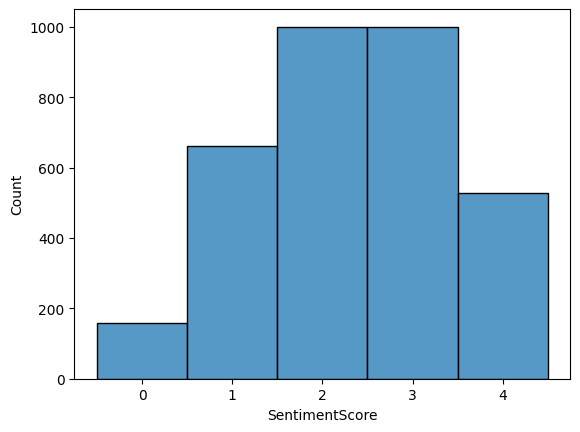

In [ ]:
sns.histplot(newdata, x='SentimentScore', discrete=True)

In [ ]:
train_dataset = dataset(newdata['EMITENT_FULL_NAME'].to_list(),
                        newdata['MessageTextClean'].to_list(),
                        newdata['SentimentScore'].to_list(),
                        tokenizer, 512)
val_dataset = dataset(val_data['EMITENT_FULL_NAME'].to_list(),
                        val_data['MessageTextClean'].to_list(),
                        val_data['SentimentScore'].to_list(),
                        tokenizer, 512)
test_dataset = dataset(test_data['EMITENT_FULL_NAME'].to_list(),
                        test_data['MessageTextClean'].to_list(),
                        test_data['SentimentScore'].to_list(),
                        tokenizer, 512)

In [ ]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=8)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

In [ ]:
from transformers import AutoTokenizer
from transformers import BertForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
model = BertForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', ignore_mismatched_sizes=True,
                                                   num_labels=5)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00001)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [ ]:
train(model, train_loader, val_loader, 4)

Epoch: 1


100%|██████████| 244/244 [00:57<00:00,  4.23it/s, Loss:  1.006, F1:  0.438]


Epochs: 1 | Train Loss:  1.283               | Train Accuracy:  0.454               | Train F1:  0.353               | Val Loss:  1.006               | Val Accuracy:  0.601               | Val F1:  0.438
Epoch: 2


100%|██████████| 244/244 [00:57<00:00,  4.25it/s, Loss:  0.939, F1:  0.496]


Epochs: 2 | Train Loss:  0.994               | Train Accuracy:  0.603               | Train F1:  0.515               | Val Loss:  0.939               | Val Accuracy:  0.616               | Val F1:  0.496
Epoch: 3


100%|██████████| 244/244 [00:57<00:00,  4.23it/s, Loss:  0.995, F1:  0.556]


Epochs: 3 | Train Loss:  0.769               | Train Accuracy:  0.716               | Train F1:  0.677               | Val Loss:  0.995               | Val Accuracy:  0.606               | Val F1:  0.556
Epoch: 4


100%|██████████| 244/244 [00:57<00:00,  4.25it/s, Loss:  0.996, F1:  0.576]


Epochs: 4 | Train Loss:  0.570               | Train Accuracy:  0.794               | Train F1:  0.772               | Val Loss:  0.996               | Val Accuracy:  0.636               | Val F1:  0.576


In [ ]:
 targets = []
 preds = []
 model.eval()
 for idx, test_batch in tqdm(enumerate(test_loader)):
    test_label = test_batch['target'].to(device)
    mask = test_batch['mask'].to(device)
    input_ids = test_batch['ids'].to(device)

    output = model(input_ids, mask, labels=test_label)
    loss, tr_logits = output.loss, output.logits
    predictions = tr_logits.argmax(dim=1).detach().cpu().numpy()
    target = test_label.detach().cpu().numpy()

    targets.extend(target.tolist())
    preds.extend(predictions.tolist())
f1_score(targets, preds, average='weighted')

105it [00:25,  4.10it/s]


0.6513655036610397

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/tsa_rubertmodel_balanced.pickle')